In [96]:
from langchain_openai import ChatOpenAI
from langchain.tools import tool
import os 
from dotenv import load_dotenv
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
from langgraph.graph import END, START, StateGraph
from typing import Literal


In [97]:

import os

os.environ['LANGSMITH_TRACING']="true"
LANGSMITH_PROJECT= os.getenv("LANGSMITH_PROJECT")
LANGSMITH_ENDPOINT=os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_API_KEY=os.getenv("LANGSMITH_API_KEY")
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [98]:
model = ChatOpenAI(model_name="gpt-4", temperature=0)
print(model)


client=<openai.resources.chat.completions.completions.Completions object at 0x11692dd60> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x11692f980> root_client=<openai.OpenAI object at 0x11692d400> root_async_client=<openai.AsyncOpenAI object at 0x11692d9a0> model_name='gpt-4' temperature=0.0 openai_api_key=SecretStr('**********') openai_proxy=''


In [99]:
@tool
def multiply(a:int, b:int)->int:
    """Multiplies two integers and returns the result."""
    return a * b

@tool 
def add(a:int, b:int)->int:
    """Adds two integers and returns the result."""
    return a + b



tools = [multiply, add]

tools_by_name = {tool.name: tool for tool in tools}

model_with_tools = model.bind_tools(tools)

In [100]:
class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [101]:
def llm_call(state:MessageState):

    return {
        "messages" : [
            model_with_tools.invoke([
                SystemMessage(content="You are a helpful assistant that can use tools to answer questions."),
            ]
            +state["messages"]
            )   
        ], 
        "llm_calls": state.get("llm_calls", 0) + 1
    }

In [102]:
def tool_node(state:MessageState):


    result = []

    for tool_call in state['messages'][-1].tool_calls:
        tool = tools_by_name[tool_call['name']]
        observation = tool.invoke(tool_call['args'])

        result.append(ToolMessage(content=observation, tool_call_id=tool_call['id']))

        return {"messages": result}


        

In [103]:
def should_continue(state:MessageState)-> Literal['tool_node', END]:

    messages = state['messages']
    last_message = messages[-1]

    if last_message.tool_calls:
        return 'tool_node'
    

    return END

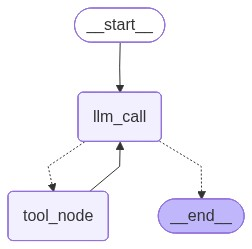

In [104]:
agent_builder = StateGraph(MessageState)


agent_builder.add_node('llm_call', llm_call)
agent_builder.add_node('tool_node', tool_node)


agent_builder.add_edge(START, 'llm_call')
agent_builder.add_conditional_edges ('llm_call', should_continue, 
                                     ['tool_node', END])

agent_builder.add_edge('tool_node', 'llm_call')


agent = agent_builder.compile()

from IPython.display import display, Image
display(Image(agent.get_graph().draw_mermaid_png()))


In [105]:
messages = HumanMessage(content="What is 12 multiplied by 13, and then add 7 to the result?")


result = agent.invoke({'messages': messages})


for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 12 multiplied by 13, and then add 7 to the result?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Wsg06AuQgwYXRMSyEEymzhhe)
 Call ID: call_Wsg06AuQgwYXRMSyEEymzhhe
  Args:
    a: 12
    b: 13
================================= Tool Message =================================

156
================================== Ai Message ==================================
Tool Calls:
  add (call_MT5QM0Zb91LU7GFfyzKfCuzV)
 Call ID: call_MT5QM0Zb91LU7GFfyzKfCuzV
  Args:
    a: 156
    b: 7
================================= Tool Message =================================

163
================================== Ai Message ==================================

The result of multiplying 12 by 13 and then adding 7 is 163.
